In [1]:
import numpy as np
import pylab as p
import scipy.integrate  as  ode
import matplotlib.pyplot  as  plt
import math
import timeit

np.set_printoptions(linewidth = 130, precision = 13)
%matplotlib inline

from scipy.optimize import fsolve
from scipy import integrate

In [2]:
#create main parameters
def parameters(n):
    #m, beta, b, k
    m = 1.5 # clearance rate + mortality/recruitment rate
    gamm = 1.2 # clearance rate
    beta = 4 #transmission rate
    k = 2 # cocolonization interaction coefficient
    
    #if gamm > m:
    #    temp1 = m
    #    m = gamm
    #    gamm = temp1 #make sure that r = m - gamma > 0
#     if m > beta:
#         temp2 = m
#         m = beta
#         beta = temp2 #make sure that m < beta

    # Perturbations:
    b = (np.random.rand(n) - np.random.rand(n))*5 #in transmission rate
    nu1d = (np.random.rand(n) - 0.5)*5 #in singled-infection clearance rate
    nu2d = (np.random.rand(n, n) - 0.5)*5 # in doubled-infection clearance rate
    alp = (np.random.rand(n, n) - 0.5)*5 # in cocolonization interaction
    
    #stable state values: S*, T*, I*, J* and determinant of matrix
    S_star = m/beta
    T_star = 1 - S_star
    I_star = m*T_star/(m + beta*k*T_star)
    J_star = T_star - I_star
    detP = 2*(T_star)**2 - I_star*J_star
    
    #coefficients for replicator equations: theta 1,2,3,4,5
    teth1 = 2*S_star*(T_star)**2/detP
    teth2 = I_star*(I_star + T_star)/detP
    teth3 = T_star*J_star/detP
    teth4 = 2*m*T_star*J_star/detP
    teth5 = beta*T_star*I_star*J_star/detP

    #fitness matrix
    lamd = np.zeros((n,n))
    for i in range (0,n):
        for j in range (0,n):
            lamd[i][j] = teth1*(b[i]-b[j]) + teth2*(-nu1d[i] + nu1d[j]) + teth3*(-nu2d[i][j]-nu2d[j][i]+2*nu2d[j][j]) + teth4*(symm[i][j] - symm[j][i])+ teth5*((I_star/J_star)*(alp[j][i] - alp[i][j]) + alp[j][i] - alp[j][j])

    return m, b, beta, gamm, nu1d, nu2d, k, alp, lamd, S_star, T_star, I_star, J_star

In [3]:
#create initial values
def initial(n):
    #random initial data for RE system
    u0 = np.random.random(n)
    u0 = u0/sum(u0)
    
    #random initial data for original quasi neutral SIS system
    I_i0 = u0*I_star #initial value for I_i
    
    I_ij_sq = np.zeros((n,n)) #initial value for I_ij
    for i in range (0, n):
        for j in range (0, n):
            I_ij_sq[i][j] = J_star*u0[i]*u0[j]
    I_ij0 = np.reshape(I_ij_sq, n*n)
    
    S0 = m/beta #initial values S
    
    #reshape the initial values into a vector
    X0 = np.zeros(n*n + n + 1) 
    for i in range (0 , n*n ): #first block: I_{ij}
        X0[i] = I_ij0[i]
    for i in range (n*n, n*n + n): #second block: I_{i}
        X0[i] = I_i0[i - n*n]
    X0[n*n + n] = S0
    return u0, X0

In [4]:
#subprogram computing RE system
def RE(n):   
    def du_dt(u, t = 0):
        return u*(np.dot(lamd,u) - np.dot(np.dot(lamd,u),u))
               
    t = np.linspace(0, 2, 40)
    
    #solve and compute the time
    start = timeit.default_timer()
    u, infodict = integrate.odeint(du_dt, u0, t, full_output=True)
    infodict['message']
    stop = timeit.default_timer()
    
    #solution at time 100
    sol_re = u.T[:,-1]
    
    return(sol_re, stop - start)

In [5]:
#compute the essential parameters for original quasi-neutral SIS system
def sym(n): #create the matrix of symmetric coefficients p^s_{ij}
    A = np.random.random((n,n))
    sym = A.T - A
    return sym

#matrix of Force infection =  beta_i * J_i for each strain
def lambd_rate(X):
    lambd = np.zeros(n)
    Y = X[0: n*n]
    Y = Y.reshape(n, n)
    for i in range (0, n):
            lambd[i] = (beta + eps*b[i])*(X[n*n + i] + np.dot(1/2 + eps*symm[i,:], Y[i,:]) + np.dot(1/2 - eps*symm[:,i], Y[:,i]))
    return lambd

In [6]:
def solveSIS(n):
    # The original quasi neutral SIS system
    def SIS(X, t = 0):
        deriv = np.zeros(n*n + n + 1)
        F = lambd_rate(X) #force F: beta_i*(I_i + sum p^s_{ij}I_{ij})
        #separate X into 3 blocks: I_{ij}, I_{i} and S
        Y = X[0: n*n]
        I_ij = Y.reshape(n,n)
        I_i = X[n*n: n*n + n]
        
        # 1st part: equations for I_ij
        Z = np.zeros((n,n))
        for i in range (0, n):
            for j in range (0, n):
                Z[i][j] = (k + eps*alp[i][j])*I_i[i]*F[j] - (m + eps*nu2d[i][j])*I_ij[i][j]        
        Z_new = Z.reshape(n*n)
        for i in range (0, n*n):
            deriv[i] = Z_new[i]
        
        #2nd part: equations for I_i
        temp = X[-1]*F - (m + eps*nu1d)*I_i - I_i*(np.dot(k + eps*alp, F))
        for i in range (n*n, n*n + n):
            deriv[i] = temp[i - n*n]
        
        #3rd part: equation for S
        deriv[-1] = (m - gamm)*(1 - X[-1]) + np.sum((gamm + eps*nu1d)*I_i) + np.sum((gamm + eps*nu2d)* I_ij) - X[-1]*np.sum(F)
        return deriv
    
    t = np.linspace(0, 20, 400)
    
    start = timeit.default_timer()
    X, infodict = integrate.odeint(SIS, X0, t, full_output=True)
    infodict['message']
    stop = timeit.default_timer()
    sol_or = X.T[:,-1]
    
    return(sol_or, stop - start)

In [7]:
nstrain = list(range(1, 51))
eps = 0.1
err = []

t_RE = []
t_SIS = []

for n in nstrain:
    # Invoke the parameters
    symm = sym(n)
    m, b, beta, gamm, nu1d, nu2d, k, alp, lamd, S_star, T_star, I_star, J_star = parameters(n)
    u0, X0 = initial(n) # invoke the initial values for 2 system: original and replicator
    
    #solve two systems
    sol_re, t1 = RE(n)
    sol_or, t2 = solveSIS(n)
    
    # Compute times of two progresses
    t_RE.append(t1)
    t_SIS.append(t2)

    #compute the error between solution of the original system and the replicator system
    #separte solution to parts: I_i, I_ij
    Y = sol_or[0: n*n]
    I_ij = Y.reshape(n,n)
    I_i = sol_or[n*n: n*n + n]
    
    #reconstruct approximation of I_ij from u_i
    u_ij = np.zeros((n,n))
    for i in range (0, n):
        for j in range (0, n):
            u_ij[i][j] = sol_re[i]*sol_re[j]
    #error
    err_cell = np.linalg.norm(sol_or[-1] - S_star) + np.linalg.norm(I_i - I_star*sol_re) + np.linalg.norm(I_ij - J_star*u_ij)
    err.append(err_cell)

In [8]:
print(err)

[0.15185952037715086, 0.11658895025486171, 0.12598803699633476, 0.06201526377435563, 0.018384989140834192, 0.05320784346678509, 0.0872718435269752, 0.02815780563190097, 0.0399840015841603, 0.021472333084018327, 0.08401287981061303, 0.04534512395851741, 0.12434784868649892, 0.06584364730040797, 0.08462811803620834, 0.05298116422483871, 0.06351855321609684, 0.05514929018374565, 0.13461253731013964, 0.05421223939657638, 0.032508619427048614, 0.04408869950420587, 0.03475291163888392, 0.057675314023846805, 0.11159484983939424, 0.11017750501537751, 0.05819091446751944, 0.05299872346180276, 0.037869850235916214, 0.03996271754056791, 0.026339712157890837, 0.0366981309171031, 0.029226318282217705, 0.056002426201625724, 0.03868486178043242, 0.034505651648999776, 0.07581844592390453, 0.047332157191928056, 0.025904077698124105, 0.039647963927950745, 0.07412249163180215, 0.03190555982685925, 0.037398009412071366, 0.045132039150131836, 0.061471130734099634, 0.038227574517422626, 0.04883366105788962,

Text(0.5, 1.0, 'Error $\\epsilon = 0.1$ with $T = 100$')

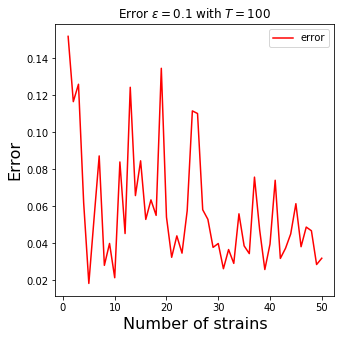

In [9]:
#plotting the error due to the number of strains at time T = 100
f1 = plt.figure(figsize=(5,5))
plt.plot(nstrain, err, 'r-', label='error')

plt.legend(loc='best')
plt.xlabel("Number of strains", fontsize=16)
plt.ylabel("Error", fontsize = 16)
plt.title("Error $\epsilon = 0.1$ with $T = 100$")

Text(0, 0.5, 'Timing of progress')

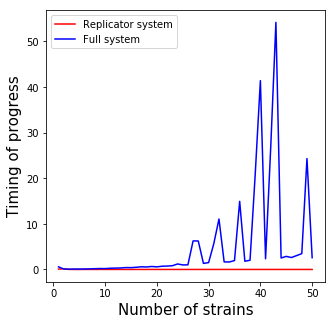

In [10]:
#plotting the time
f2 = plt.figure(figsize=(5, 5))

plt.plot(nstrain, t_RE, 'r', label = 'Replicator system')
plt.plot(nstrain, t_SIS, 'b', label = 'Full system')
plt.xlim = (2,10)
plt.legend(loc='best')
plt.xlabel("Number of strains", fontsize=15)
plt.ylabel("Timing of progress", fontsize = 15)

Text(-0.1, 1.1, 'b')

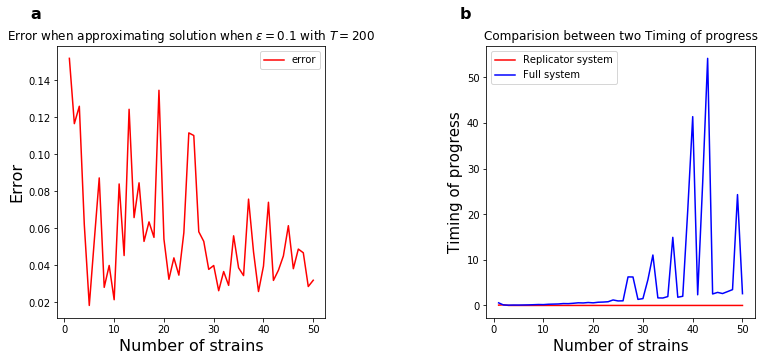

In [11]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize = (12.5, 5))
fig.subplots_adjust(wspace = 0.6)

ax1.plot(nstrain, err, 'r-', label='error')
ax1.legend(loc='best')
ax1.set_xlabel("Number of strains", fontsize=16)
ax1.set_ylabel("Error", fontsize = 16)
ax1.set_title("Error when approximating solution when $\epsilon = 0.1$ with $T = 200$")

ax2.plot(nstrain, t_RE, 'r', label = 'Replicator system')
ax2.plot(nstrain, t_SIS, 'b', label = 'Full system')
ax2.legend(loc='best')
ax2.set_xlabel("Number of strains", fontsize=15)
ax2.set_ylabel("Timing of progress", fontsize = 15)
ax2.set_title("Comparision between two Timing of progress")

ax1.text(-0.1, 1.1, 'a', transform=ax1.transAxes, size=16, weight='bold')
ax2.text(-0.1, 1.1, 'b', transform=ax2.transAxes, size=16, weight='bold')